<a href="https://colab.research.google.com/github/alexmoed/MasterClass/blob/2D-MatAnyone/Sam2_MatAnyone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd

Mounted at /content/drive
/root


##SAM2 + MatAnyone
This pipeline creates a seamless integration between SAM2 mask prediction and MatAnyone for mask propagation across video frames. The system automatically passes masks and paths between components for efficient video object segmentation.

In [ ]:

"""

Code for processing SAM2 video segmentation masks

Modified from Meta AI Research's SAM2 repository:

https://github.com/facebookresearch/sam2

Reference:

Meta AI Research. (2025). SAM2: Segment Anything Model 2.

GitHub repository. https://github.com/facebookresearch/sam2
# Copyright (c) Meta Platforms, Inc. and affiliates.
"""

"""
@code MatAnyone video mask propagation implementation

Modified from:-
Yang, H. et al. (March 2025). MatAnyone: Universal Video Matting [online].
[Accessed 2025-05-04]. Available from: "https://matanyone.com/about".
"""

## Environment Set-up
If running locally using jupyter, first install `sam2` in your environment using the [installation instructions](https://github.com/facebookresearch/sam2#installation) in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [2]:
using_colab = True

In [3]:
#Getting checkpoints for sam2 and importing torch and tourchvision
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'


    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-rolqpoku
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-rolqpoku
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8

In [4]:
 #Get example videos
 """!mkdir -p videos
    !wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
    !unzip -d videos videos/bedroom.zip"""

'!mkdir -p videos\n   !wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip\n   !unzip -d videos videos/bedroom.zip'

## Set-up

In [2]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Loading the SAM 2 video predictor

In [4]:
from sam2.build_sam import build_sam2_video_predictor
#There are other checkpoints avaiable but this one seems to work

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [5]:
#Defining masking and points display
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

**Put the path to the folder containing the image sequence first frame will be masked (only one sequence per folder) **





/content/drive/MyDrive/Visual_skies_living_room_tests/Chair/Sequence_6


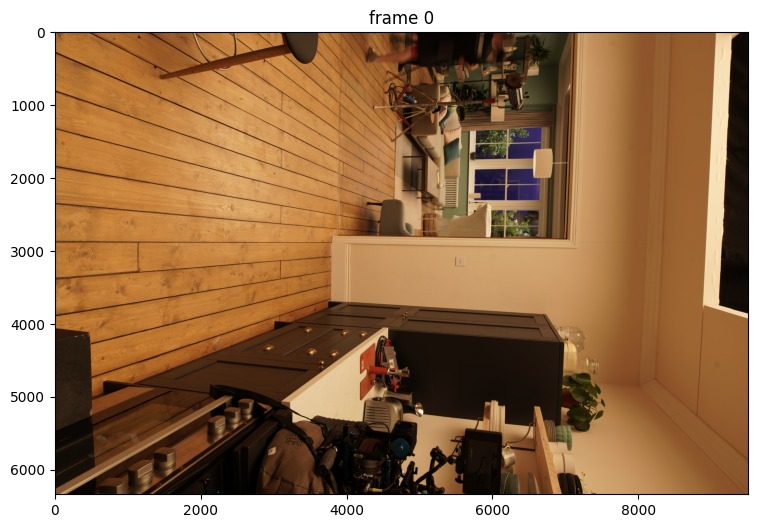

In [6]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
#Please note it should not include file names it works best with ####.jpg format
video_dir = "/content/drive/MyDrive/Visual_skies_living_room_tests/Chair/Sequence_6"

#scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))


#take a look the first video frame
frame_idx = 0 #First frame starts at 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))
print(video_dir)

#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [11]:
#run first getting inference
inference_state = predictor.init_state(video_path=video_dir)


frame loading (JPEG): 100%|██████████| 14/14 [00:22<00:00,  1.61s/it]


This the following is only to totally reset the predictions and mask do not run each time unless you want to erase your progress.


In [16]:
reset = str(input("Are you sure you want to reset? Enter Yes to reset"))
#added a simple check to make sure the reset doesnt run by accident
if reset.lower() == "yes":
    predictor.reset_state(inference_state)
    print("Reset complete:You will have to rerun inference_state")
else:
      print("Skipping Reset")
#Its very annoying when this runs by accident

Are you sure you want to reset? Enter Yes to resetyes
Reset complete:You will have to rerun inference_state


Add a first clicks on frame 1

This is where we add our clicks(stars) to tell Sam2 what to track. (one object at this step)
Here we make a **positive click** at [4500, 2520] with label `1`, by sending their coordinates and labels into the `add_new_points_or_box` API.

Note: label `1` indicates a *positive click (To add a region)* while label `0`  indicates a *negative click (to remove a region)*.

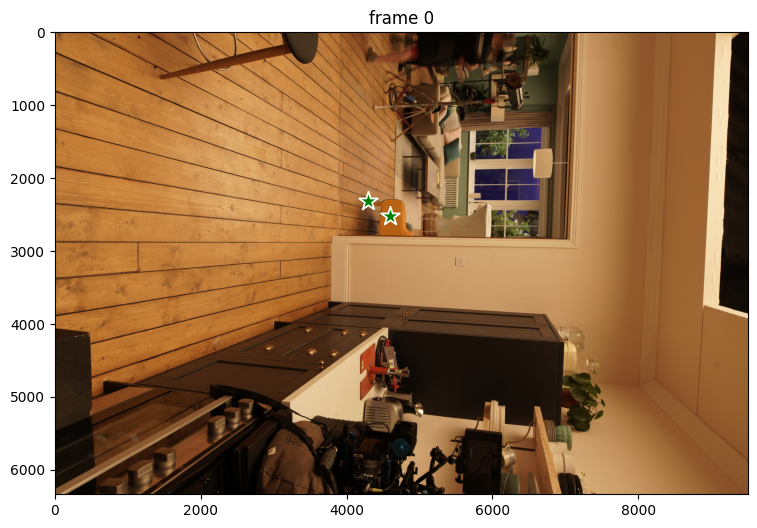

In [18]:

prompts = {}
frame_idx = 0 # the frame index we interact with
ann_obj_id = 1 #this current implimentation is designed to work with 1 object
ann_frame_idx = frame_idx
#We are taking the first frame and adding markers of the objects we want to trace and red markers of objects we dont want to trace


# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
#corindates for the 3 markers feel free to add more but update the labels np array
]
# sending all clicks (and their labels) to `add_new_points_or_box`
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))
points = np.array([[4600, 2520],[4300, 2320]], dtype=np.float32) #This is where you add more points add the cordinates each array is a click (point)
labels = np.array([ 1,1], np.int32) #This is where we label the points. it follows the same order as the np array and has to have the same number as arrays. For example 2 arrays in points 2 number in labels.
# for labels, `1` means positive click and `0` means negative click

prompts[ann_obj_id] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,

)

# show the results on the current (interacted) frame

plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])


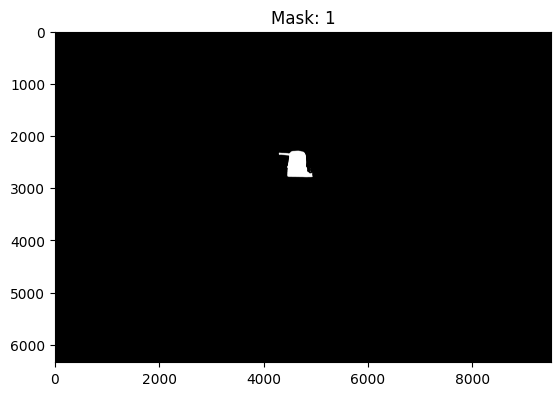

In [19]:
#We are getting mask predictions out of the model
mask = (out_mask_logits[0] > 0.0).cpu().numpy()

#2D by removing any singleton dimensions
mask = np.squeeze(mask)

#Show the mask
plt.figure()
plt.imshow(mask, cmap='gray')
plt.title(f"Mask: {ann_obj_id}")
plt.show()

**Next step we are taking the mask from Sam and then using Mat anyone to propgate the mask over multiple frames This is where matAnyone Starts**

In [20]:
#put in the path to your
#!git clone https://github.com/pq-yang/MatAnyone.git /content/drive/MyDrive/Mat_anyone
%cd /content/drive/MyDrive/Mat_anyone

/content/drive/MyDrive/Mat_anyone


# Install dependencies for Mat anyone
We are now installing the correct versions for Mat anyone

In [21]:
!pip install omegaconf
import imageio.v2 as imageio
import numpy as np
from PIL import Image


In [22]:
#Uninstalling because sam2 requires a different version from Mat Anyone
!pip uninstall -y numpy

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2


In [23]:
!pip uninstall -y hydra-core omegaconf

Found existing installation: hydra-core 1.3.2
Uninstalling hydra-core-1.3.2:
  Successfully uninstalled hydra-core-1.3.2
Found existing installation: omegaconf 2.3.0
Uninstalling omegaconf-2.3.0:
  Successfully uninstalled omegaconf-2.3.0


In [24]:
# install python dependencies
!pip install -e .
# [optional] install python dependencies for gradio demo
!pip3 install -r hugging_face/requirements.txt
!pip install hydra-core
#Its going to ask you to restart the session dont

Obtaining file:///content/drive/MyDrive/Mat_anyone
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Cloning https://github.com/cheind/py-thin-plate-spline to /tmp/pip-install-ah57zrh0/thinplate_00f618d658f34d7087314697b1132563
  Running command git clone --filter=blob:none --quiet https://github.com/cheind/py-thin-plate-spline /tmp/pip-install-ah57zrh0/thinplate_00f618d658f34d7087314697b1132563
  Resolved https://github.com/cheind/py-thin-plate-spline to commit f6995795397118b7d0ac01aecd3f39ffbfad9dee
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached hydra_core-1.3.2-py3-none-any.whl.metadata (5.5 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━

  Cloning https://github.com/cheind/py-thin-plate-spline to /tmp/pip-req-build-d9i7enxj
  Running command git clone --filter=blob:none --quiet https://github.com/cheind/py-thin-plate-spline /tmp/pip-req-build-d9i7enxj
  Resolved https://github.com/cheind/py-thin-plate-spline to commit f6995795397118b7d0ac01aecd3f39ffbfad9dee
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-idwrp854
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-idwrp854
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 13.3 MB/s eta 

In [25]:
#We are working out of the Mat-anyone directory change to match where you installed it
%cd /content/drive/MyDrive/Mat_anyone

/content/drive/MyDrive/Mat_anyone


In [ ]:
from PIL import Image
import os
!pip install numpy

import numpy as np

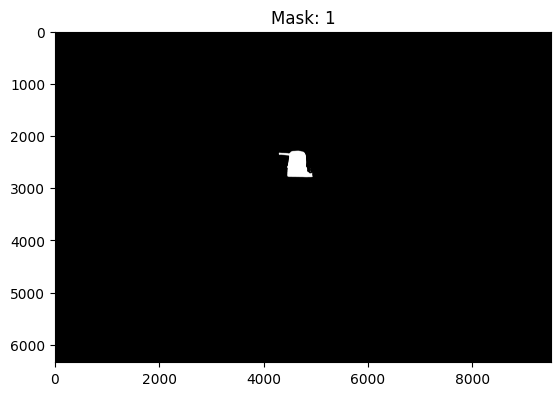

In [26]:

# review the mask from sam2
plt.figure()
plt.imshow(mask, cmap='gray')
plt.title(f"Mask: {ann_obj_id}")
plt.show()

In [27]:
#I am combining the path where the images are and adding a new folder to put the results, I want this to be as automatic as a possible
output_dir = f'{video_dir}/mask_output/'
resize_mask = f'{video_dir}/resize_output/mask_prediction.png'
print(output_dir)

/content/drive/MyDrive/Visual_skies_living_room_tests/Chair/Sequence_6/mask_output/


Preparing the Mask to work with Mat anyone. We need to save a temp mask because Mat anyone is designed to import image files and was not able to get it to accept a array

In [28]:

#Converting the mask from PIL to NParray
mask_array = np.array(mask)
print(np.unique(mask_array))

#Converting binary mask to 0–255 if it's a boolean mask (or values 0 and 1)
data = (mask_array.astype(np.uint8)) * 255


#Save out a greyscale image for the mask
Image.fromarray(data, mode='L').save(f"{video_dir}/mask_prediction.png")


[False  True]


In [29]:
#Check the paths
print(video_dir)
print(output_dir)


/content/drive/MyDrive/Visual_skies_living_room_tests/Chair/Sequence_6
/content/drive/MyDrive/Visual_skies_living_room_tests/Chair/Sequence_6/mask_output/


In [35]:
# Create directory for resized images
os.makedirs(f"{video_dir}/resized_image_seq", exist_ok=True)

# Resize frames to 1920x1080 (Full HD) which is divisible by 16
for frame in frame_names:
    img = Image.open(os.path.join(video_dir, frame))
    resized_img = img.resize((2048, 1088), Image.LANCZOS)  #added 8 pixels because the image writer required it
    resized_img.save(f"{video_dir}/resized_image_seq/{frame}")

# Resizing mask to the same dimensions
mask = Image.open(f"{video_dir}/mask_prediction.png")
resized_mask = mask.resize((2048, 1088), Image.LANCZOS) #added 8 pixels because the image writer required it
resized_mask.save(f"{video_dir}/mask_prediction-resize.png")

# Running the MatAnyone model
Resize_dir = f"{video_dir}/resized_image_seq"
!python inference_matanyone.py -i {Resize_dir} -m {video_dir}/mask_prediction-resize.png --save_image -o {output_dir}

100% 24/24 [00:05<00:00,  4.48it/s]
